## Feature Extaction Test

In [1]:
import sys; sys.path.insert(0, '..')
from database.dataset import *

from feature_extraction.feature_extraction import CandidatesFeatureExtraction
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from general_utils.plots import plot_bboxes_over_image, simple_im_show, simple_im_show2
from metrics.metrics import get_tp_fp_fn, quick_circle_comparison, circle_comparison


### Database initialization

In [2]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        max_lesion_diam_mm=1.0,
        partitions=['train'],
        extract_patches=True,
        extract_patches_method='all',  # 'centered'
        patch_size=256,
        stride=256,
        min_breast_fraction_roi=0.5,
        normalize=None,
        n_jobs=-1,
)

### Detectors Parameters and initialization

In [3]:
dehazing_params = {'omega': 0.9, 'window_size': 11, 'radius': 40, 'eps': 1e-5}

hough1_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 8,  'minRadius': 2, 'maxRadius': 20}

hough2_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 10,  'minRadius': 2, 'maxRadius': 20}

back_ext_radius = 50

erosion_iter = 20
erosion_size = 5


hd = HoughCalcificationDetection(dehazing_params, back_ext_radius,
                                 Path.cwd().parent / 'data/hough_img',    # "/media/vzalevskyi/DATA/ProjectsData/calc-det/no_dehaizing",
                                 hough1_params, hough2_params,
                                 erosion_iter=erosion_iter,
                                 erosion_size=erosion_size)


### Detector initialization

In [4]:
# FE class initialization
cfe  = CandidatesFeatureExtraction(patch_size=30)


### FE

In [8]:
idx = 0
fdf = []
for idx in tqdm(range(len(db))):
    # extracting data
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db.df.iloc[idx].img_id
    image_mask = db_sample['lesion_mask']

    # candidate selection
    h1_circles = hd.detect(image, image_id, load_processed_images=True, hough2=False)[0]

    rbd_image = cv2.imread(f'/home/vzalevskyi/projects/calc-det/data/recounstructed_by_dialation_img/{image_id}.tiff', cv2.IMREAD_ANYDEPTH)
    rbd_image[rbd_image<np.quantile(rbd_image, q=0.97)] = 0
    
    # feature extraction
    res = pd.DataFrame(cfe.extract_features(h1_circles, image, image_mask, sample=2))
    res['img_id'] = image_id
    
    # classification
    
    fdf.append(res)

100%|██████████| 154/154 [01:15<00:00,  2.05it/s]


### Classification

In [9]:
from sklearn.svm import SVC

from sklearn.metrics import f1_score, roc_auc_score

from sklearn.preprocessing import MinMaxScaler

In [10]:
all_data_df = pd.concat(fdf).sample(frac=1) # merge and shuffle
data = all_data_df.drop(columns=['coordinates'])
data.head(10)

,img_energy,img_entropy,img_uniformity,img_min,img_10th_perc,img_90th_perc,img_max,img_mean,img_meadian,img_inter_quartile_range,img_range,img_mean_abs_deviation,img_robust_mean_abs_deviation,img_rms,img_std,img_skew,img_kurt,patch_mask_intersection,img_id
134,430.670071,7.532521,0.006383,0.616992,0.659246,0.721990,0.659246,0.691325,0.690822,0.033280,0.042254,0.019707,0.014123,0.691753,0.024342,0.134099,-0.198106,0.0,20587492
67,186.646893,7.755513,0.005457,0.413397,0.434641,0.475881,0.434641,0.455100,0.454886,0.023244,0.021245,0.013099,0.009238,0.455396,0.016419,0.274098,-0.006252,0.0,24058738
158,436.083040,7.610147,0.005965,0.625203,0.663821,0.724797,0.663821,0.695681,0.696748,0.031809,0.038618,0.018973,0.013400,0.696087,0.023772,-0.195863,-0.050316,0.0,24055752
178,360.689260,7.792883,0.005170,0.574380,0.604649,0.662913,0.604649,0.632649,0.630854,0.030647,0.030269,0.018084,0.012569,0.633061,0.022832,0.392986,0.070852,0.0,22613770
8,373.152031,8.367434,0.003622,0.561702,0.587943,0.726631,0.587943,0.641784,0.631738,0.060993,0.026241,0.040284,0.027051,0.643905,0.052212,1.118476,0.648095,36.0,22670465
27,490.995379,8.266027,0.003827,0.633929,0.683847,0.801948,0.683847,0.737227,0.731331,0.066964,0.049919,0.037236,0.027393,0.738614,0.045238,0.309314,-0.520602,0.0,22614568
7,455.757372,7.594550,0.006111,0.633517,0.677716,0.746363,0.677716,0.711111,0.709945,0.033149,0.044199,0.020749,0.013950,0.711616,0.026797,0.220050,0.319827,1.0,22427864
86,505.416376,7.595477,0.006123,0.668504,0.718482,0.779610,0.718482,0.748976,0.748834,0.032323,0.049979,0.019488,0.013402,0.749382,0.024685,0.098387,0.205280,0.0,24055725
151,493.203310,7.435960,0.006812,0.670150,0.711040,0.767924,0.711040,0.739926,0.739437,0.031349,0.040891,0.018080,0.012745,0.740273,0.022661,0.096692,-0.063428,0.0,20587492
284,436.799892,8.011001,0.004659,0.575067,0.649145,0.733219,0.649145,0.695857,0.699734,0.039149,0.074078,0.025537,0.016692,0.696659,0.033408,-0.748849,0.697102,0.0,22613822


In [11]:
f1_metrics = []
rocauc_metrics = []

for test_img_id in tqdm(data.img_id.unique()):
    train_df = data[data.img_id != test_img_id]
    test_df = data[data.img_id == test_img_id]

    train_X, train_y = train_df.drop(columns=['patch_mask_intersection']), (train_df.patch_mask_intersection>0).astype(int)
    test_X, test_y = test_df.drop(columns=['patch_mask_intersection']), (test_df.patch_mask_intersection>0).astype(int)

    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    test_X_scaled = scaler.transform(test_X)

    svc = SVC(C=10, probability=False)
    svc.fit(train_X_scaled, train_y)

    train_y_predicted = svc.predict(train_X_scaled)
    # train_y_predicted_proba = svc.predict_proba(train_X_scaled)
    
    test_y_predicted = svc.predict(test_X_scaled)
    # test_y_predicted_proba = svc.predict_proba(test_X_scaled)
    
    
    f1_metrics.append((f1_score(train_y, train_y_predicted), f1_score(test_y, test_y_predicted)))
    # plt.boxplot(np.array(f1_metrics))
    # plt.show()
    # rocauc_metrics.append((roc_auc_score(train_y, train_y_predicted_proba), roc_auc_score(test_y, test_y_predicted_proba)))

100%|██████████| 149/149 [09:14<00:00,  3.72s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

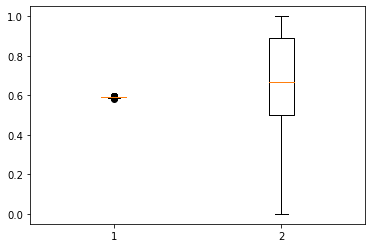

In [12]:
plt.boxplot(np.array(f1_metrics))
plt.show()

## NEW Features

### GLCM

In [13]:
from general_utils.utils import min_max_norm
from skimage import feature

In [28]:
image = db[0]['img']
# not sure if agnles are what I need to get left<->right with d=2
image_patch = min_max_norm(image[300:330, 330:360], max_val=255).astype(np.uint8) # needs conversion for GLCM generation

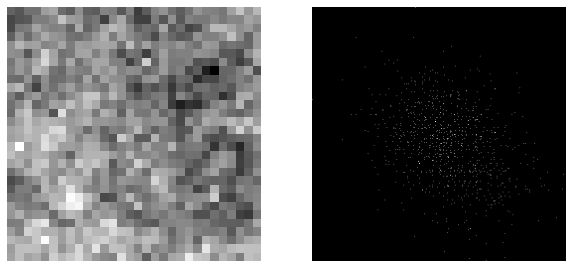

In [32]:
simple_im_show2(image_patch, feature.greycomatrix(image_patch, [2], [0, np.pi])[:,:,0,0])

In [35]:
glcm_distancs = [2]
glcm_angles = [0, np.pi]
glcm = feature.greycomatrix(image_patch, glcm_distancs, glcm_angles)
glcm.shape

(256, 256, 1, 2)

In [41]:
glcm_features = {}

skimage_glcm_features = ['energy','correlation','homogeneity','contrast','dissimilarity','ASM']
for feature_name in skimage_glcm_features:
    feature_values = feature.greycoprops(glcm, prop=feature_name)
    for fv_idx, fv in enumerate(feature_values.ravel()):
        glcm_features[f'glcm_{feature_name}_{fv_idx}'] = fv

In [50]:
glcm.shape

(256, 256, 1, 2)

In [42]:
def compute_custom_glcm_featurs(G):
    entropy, uniformity = CandidatesFeatureExtraction.entropy_uniformity(G)
    # sum average?
    # sum entropy?
    # difference entropy?
    sum_squares = (G*(1- G.mean())**2).sum()
    inverse_diff = 0
    idx_grid = np.indices((G.shape[0], G.shape[1]))
    autocorrelation = (idx_grid[0, :, :]*idx_grid[1, :, :]*G).sum()
    

{'glcm_energy_0': 0.03626558621839956,
 'glcm_energy_1': 0.03626558621839956,
 'glcm_correlation_0': 0.34565349040842414,
 'glcm_correlation_1': 0.3456534904084243,
 'glcm_homogeneity_0': 0.029272673048637537,
 'glcm_homogeneity_1': 0.029272673048637555,
 'glcm_contrast_0': 1901.1630952380947,
 'glcm_contrast_1': 1901.1630952380963,
 'glcm_dissimilarity_0': 34.70357142857142,
 'glcm_dissimilarity_1': 34.703571428571436,
 'glcm_ASM_0': 0.001315192743764172,
 'glcm_ASM_1': 0.0013151927437641717}

### Gabor Filters

In [54]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi


In [ ]:


def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats